In [2]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pylab as plt
from matplotlib import cm
from numpy import sin, cos, tan, exp, pi, e

# Defining the variables and equations of motion

In [3]:
X_LABEL = "r"
Y_LABEL = "s"
ANG = 3*pi/4

def DXDT(x, y):
    return(2*x*(1-x-y))
    
def DYDT(x, y):
    return(y*(2-y-4*x))

# Rendering the phase portrait

In [4]:
from scipy.optimize import fsolve, root
from itertools import product

## Function to find the critical points, (do not change)
def find_2D_critical_points(dxdt, dydt, epsilon=0.0001, res_c=0.1, xlim=(-3, 3), ylim=(-3, 3)):
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    ## Helper function needed for fsolve
    def DDT(arg):
        x, y = arg
        return(dxdt(x, y), dydt(x, y))

    ## Creating a grid to search for critical points
    x = np.arange(*xlim, res_c)
    y = np.arange(*ylim, res_c)
    X, Y = np.meshgrid(x, y)

    ## Finding the critical points
    cp_x = []
    cp_y = []
    for x_0, y_0 in product(x, y):
        x_c, y_c = fsolve(DDT, (x_0, y_0), factor=1.0)
        
        # Checking if its in range
        if (x_c >= x_min) & (x_c <= x_max) & (y_c >= y_min) & (y_c <= y_max):
            if len(cp_x) > 0:
                # Check to make sure the point is not already included
                is_included = np.any(np.abs(np.array(cp_x) - x_c) < epsilon) & np.any(np.abs(np.array(cp_y) - y_c) < epsilon)
                if not is_included:
                    cp_x.append(x_c)
                    cp_y.append(y_c)
            else:
                # first point
                cp_x.append(x_c)
                cp_y.append(y_c)
    
    cp_x = np.array(cp_x)
    cp_y = np.array(cp_y)
    
    # Checking which ones actually worked
    actually_worked = np.isclose(dxdt(cp_x, cp_y), np.zeros(len(cp_x))) * np.isclose(dydt(cp_x, cp_y), np.zeros(len(cp_x)))
    cp_x = cp_x[actually_worked]
    cp_y = cp_y[actually_worked]

    ## Sorting the lists of critical points
    sort_x = np.argsort(cp_x)
    cp_x = cp_x[sort_x]
    cp_y = cp_y[sort_x]
    sort_y = np.argsort(cp_y)
    cp_x = cp_x[sort_y]
    cp_y = cp_y[sort_y]

    print("Critical points found at:")            
    print([i for i in zip(cp_x, cp_y)])
    print()
    return cp_x, cp_y

# Function for plotting the phase diagram (do not change)
def plot_2D_phase_space(dxdt, dydt, xlim=(-3, 3), ylim=(-3, 3), res=0.1, q_scale=1.0, x_label=X_LABEL, y_label=Y_LABEL, ax=None, figsize=(6,6)):
    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1,aspect='equal')

    ## Creating the Grid for plotting
    x = np.arange(*xlim, res)
    y = np.arange(*ylim, res)
    X, Y = np.meshgrid(x, y)

    ## Caculating the change vectors
    dxdt_q = dxdt(X, Y)
    dydt_q = dydt(X, Y)
    max_ddt = np.max(np.sqrt(dxdt_q**2 + dydt_q**2))

    ## Finding critical points 
    cp_x, cp_y = find_2D_critical_points(dxdt, dydt, xlim=xlim, ylim=ylim)

    ## Plotting quivers and critical points
    ax.axhline(0, color='.8')
    ax.axvline(0, color='.8')
    ax.set_xlim(xlim)
    ax.scatter(cp_x, cp_y, s=100, color='blue', marker='o', facecolor='none')
    ax.quiver(x, y, dxdt_q, dydt_q, scale_units='width', scale=max_ddt/(.1 * q_scale), color='blue')
    ax.set_title("2D phase portrait")
    ax.set_ylim(ylim)
    ax.set_xlabel(X_LABEL)
    ax.set_ylabel(Y_LABEL)

In [5]:
# Setting plotting defaults
X_MIN = -.2 # minimum X value shown
X_MAX = 2.2 # maximum X value shown
Y_MIN = -.2 # minimum Y value shown
Y_MAX = 2.2 # maximum Y value shown

RES = 0.2 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 10.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

Critical points found at:
[(0.0, 0.0), (1.00000000001412, 1.9675761282793446e-19), (0.33333333333173865, 0.6666666666681964), (2.315101241013593e-19, 2.0)]



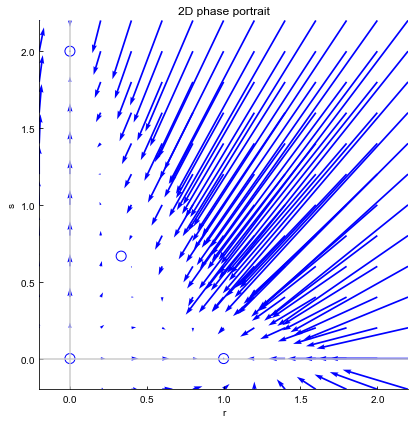

In [6]:
plot_2D_phase_space(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE)

# Simulating solutions to the system

In [8]:
# Setting default timestep
DT = 0.001

# Function to plot phase space diagram w/ critical points 
from itertools import product

# Functions implimenting Euler's method
def find_next_point_Euler(x, y, dxdt, dydt, dt=DT):
    x_next = x + dxdt(x,y)*dt
    y_next = y + dydt(x,y)*dt
    return(x_next, y_next)

# Function implimenting the midpoint method aka RK2
def find_next_point_midpoint(x, y, dxdt, dydt, dt=DT):
    x_test = x + dxdt(x,y)*dt
    y_test = y + dydt(x,y)*dt
    
    x_next = x + dxdt((x + x_test)/2., (y + y_test)/2)*dt
    y_next = y + dydt((x + x_test)/2., (y + y_test)/2)*dt
    
    return(x_next, y_next)

def simulate(x_0, y_0, t_f, dxdt, dydt, simulation_function, dt=DT):
    X_solution = [x_0]
    Y_solution = [y_0]
    T = np.arange(dt, t_f, dt)
    for t in T[1:]:
        x_previous, y_previous = X_solution[-1], Y_solution[-1]
        x_next, y_next = simulation_function(x_previous, y_previous, dxdt, dydt, dt=dt)
        X_solution.append(x_next)
        Y_solution.append(y_next)
    return (T, X_solution, Y_solution)

def simulate_collection(X_0s, Y_0s, t_f, dxdt, dydt, simulation_function, dt=DT):
    X = []
    Y = []
    for X_0, Y_0 in zip(X_0s, Y_0s):
        T, X_sol, Y_sol = simulate(X_0, Y_0, t_f, dxdt, dydt, simulation_function, dt=dt)
        X.append(X_sol)
        Y.append(Y_sol)
    return T, X, Y

def plot_solutions(T_f, X_0s, Y_0s, dxdt, dydt, simulation_functions, colors=['.k'],dt=DT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE, x_label=X_LABEL, y_label=Y_LABEL):
    fig, (ax, ax_x, ax_y) = plt.subplots(figsize=(12,4), ncols=3)
    plot_2D_phase_space(dxdt, dydt, xlim=xlim, ylim=ylim, res=res, q_scale=q_scale, x_label=x_label, y_label=y_label, ax=ax)
    ax.set_aspect(aspect='equal')

    X_solutions = []
    Y_solutions = []
    for simulation_function, (X_0, Y_0) in product(simulation_functions, zip(X_0s, Y_0s)):
        T, X_solution, Y_solution = simulate(X_0, Y_0, T_f, dxdt, dydt, simulation_function, dt=dt)
        X_solutions.append(X_solution)
        Y_solutions.append(Y_solution)

    if len(colors) != len(X_solutions):
        colors = len(X_solutions) * colors

    for X_solution, Y_solution, color in zip(X_solutions, Y_solutions, colors):
        ax.plot(X_solution, Y_solution, color=color)
        ax.scatter(X_solution[0], Y_solution[0], color=color, zorder=10, s=10.0)

        ax_x.set_title("{0} vs. time".format(X_LABEL))
        ax_x.plot(T, X_solution, color=color)
        ax_x.axhline(0, color='.8', zorder=-1)
        ax_x.scatter(T[0], X_solution[0], color=color, zorder=10, s=10.0)
        ax_x.set_ylabel(X_LABEL)
        ax_x.set_xlabel("Time")
        ax_x.set_ylim(xlim)

        ax_y.set_title("{0} vs. time".format(Y_LABEL))
        ax_y.plot(T, Y_solution, color=color)
        ax_y.axhline(0, color='.8', zorder=-1)
        ax_y.scatter(T[0], Y_solution[0], color=color, zorder=10, s=10.0)
        ax_y.set_ylabel(Y_LABEL)
        ax_y.set_xlabel("Time")
        ax_y.set_ylim(ylim)

### Graphing the RK2 simulation

In [9]:
X_0 = 0.999 # starting x value
Y_0 = 2 # starting y value
T_f = 30 # final time, initial time is always 0

DT = 0.001 # simulation timestep

X_MIN = -.2 # minimum X value shown
X_MAX = 2.2 # maximum X value shown
Y_MIN = -.2 # minimum X value shown
Y_MAX = 2.2 # maximum X value shown

RES = 0.2 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 1.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

Critical points found at:
[(0.0, 0.0), (1.00000000001412, 1.9675761282793446e-19), (0.33333333333173865, 0.6666666666681964), (2.315101241013593e-19, 2.0)]



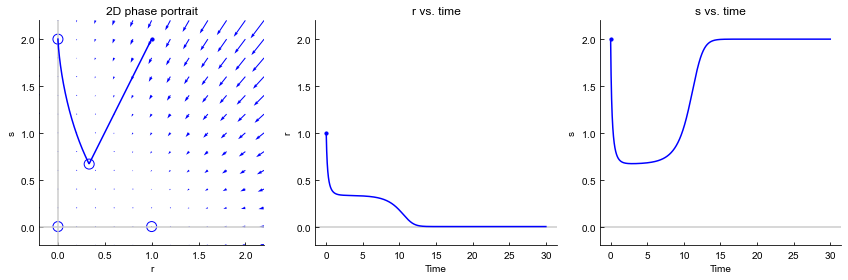

In [10]:
plot_solutions(T_f, [X_0], [Y_0], DXDT, DYDT, [find_next_point_midpoint], colors=['b'], dt=DT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE)

## Plotting a set of trajectories

In [53]:
X_MIN = -.2 # minimum X value shown
X_MAX = 2.2 # maximum X value shown
Y_MIN = -.2 # minimum Y value shown
Y_MAX = 2.2 # maximum Y value shown

X_0s = [0, .25, .5, .75, 1] # list of starting X values
Y_0s = [1, .75, .5, .25, 0] # list of starting Y values
T_f = 10 # Final simulation time, initial time is 0

RES = 0.5 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 5.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

Critical points found at:
[(0.0, 0.0), (1.00000000001412, 1.9675761282793446e-19), (0.33333333333173865, 0.6666666666681964), (2.315101241013593e-19, 2.0)]



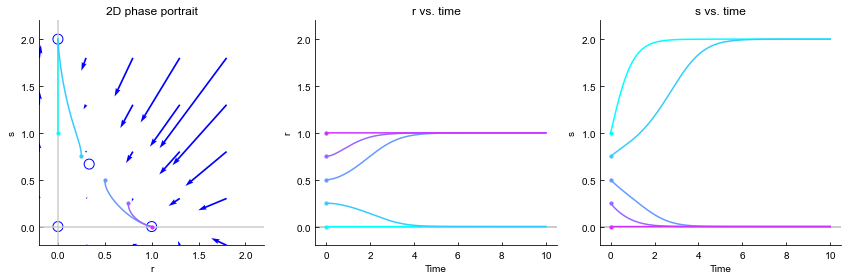

In [54]:
plot_solutions(T_f, X_0s, Y_0s, DXDT, DYDT, [find_next_point_midpoint], colors=[cm.cool(i / float(len(X_0s))) for i in range(len(X_0s))], dt=0.001, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE)

# Approximating dynamics near the critical points

In [13]:
# Some functions to "linearize" a system near crtical points and find eigenvalues and vectors there 

# Function to "linearize" non-linear systems near a point (do not change)
def linearize(x, y, dx_func, dy_func, D=0.000001):
    L = np.array(
        [[(dx_func(x+D,y) - dx_func(x-D,y)) / (2*D), (dx_func(x,y+D) - dx_func(x,y-D)) / (2*D)], 
        [(dy_func(x+D,y) - dy_func(x-D,y)) / (2*D), (dy_func(x,y+D) - dy_func(x,y-D)) / (2*D)]]
    )
    return(L)

# Function to "linearize" non-linear system near all critical points 
def linearize_all_critical_points(dxdt, dydt, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX)):
    cp_x, cp_y = find_2D_critical_points(dxdt, dydt, xlim=xlim, ylim=ylim)
    Ls = []
    for i, (x, y) in enumerate(zip(cp_x, cp_y)):
        L = linearize(x, y, DXDT, DYDT)
        Ls.append(L)
        print(f" At critical point #{i}, ({x}, {y}), the functions are approximated by \n {L}\n")
    return Ls, cp_x, cp_y

# Function to find and print eigenvalues and eigenvectors of a matrix (do not change)
def find_eigenvalues_and_eigenvectors(M):
    vals, mat = eig(M)
    for i in range(len(vals)):
        if np.imag(vals[i]) == 0.0:
            vals = np.array(vals, dtype='float')
        print(f"\tEigenvalue {i+1} is {vals[i]:.3}, with vector ({mat[0,i]:.3}, {mat[1,i]:.3})")
    return vals, mat

# A function to find and print eigenvalues and eigenvectors at all crtiical points (do not change)
def find_all_critcal_eigenvalues_and_eigenvectors(dxdt, dydt, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX)):
    Ls, cp_x, cp_y = linearize_all_critical_points(dxdt, dydt)
    vals = []
    mats = []
    for i, (L, x, y) in enumerate(zip(Ls, cp_x, cp_y)):
        print(f"At critical point #{i}, ({x}, {y}),")
        val, mat = find_eigenvalues_and_eigenvectors(Ls[i])
        print("")
        vals.append(val)
        mats.append(mat)
    return vals, mats, Ls, cp_x, cp_y

In [14]:
Ls, cp_x, cp_y = linearize_all_critical_points(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX))    

Critical points found at:
[(0.0, 0.0), (1.00000000001412, 1.9675761282793446e-19), (0.33333333333173865, 0.6666666666681964), (2.315101241013593e-19, 2.0)]

 At critical point #0, (0.0, 0.0), the functions are approximated by 
 [[2. 0.]
 [0. 2.]]

 At critical point #1, (1.00000000001412, 1.9675761282793446e-19), the functions are approximated by 
 [[-2.00000000e+00 -2.00000000e+00]
 [-7.87030451e-19 -2.00000000e+00]]

 At critical point #2, (0.33333333333173865, 0.6666666666681964), the functions are approximated by 
 [[-0.66666667 -0.66666667]
 [-2.66666667 -0.66666667]]

 At critical point #3, (2.315101241013593e-19, 2.0), the functions are approximated by 
 [[-2.00000000e+00 -4.63020248e-19]
 [-8.00000000e+00 -2.00000000e+00]]



In [72]:
vals, mats, Ls, cp_x, cp_y = find_all_critcal_eigenvalues_and_eigenvectors(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX))

Critical points found at:
[(0.0, 0.0), (2.0, 0.0), (1.0, 1.0), (0.0, 2.0), (0.0, 4.0)]

 At critical point #0, (0.0, 0.0), the functions are approximated by 
 [[2. 0.]
 [0. 4.]]

 At critical point #1, (2.0, 0.0), the functions are approximated by 
 [[-2. -2.]
 [ 0. -2.]]

 At critical point #2, (1.0, 1.0), the functions are approximated by 
 [[-1. -1.]
 [-3. -1.]]

 At critical point #3, (0.0, 2.0), the functions are approximated by 
 [[ 2.11758237e-16  0.00000000e+00]
 [-6.00000000e+00 -2.22044605e-10]]

 At critical point #4, (0.0, 4.0), the functions are approximated by 
 [[ -2.   0.]
 [-12.  -4.]]

At critical point #0, (0.0, 0.0),
	Eigenvalue 1 is 2.0, with vector (1.0, 0.0)
	Eigenvalue 2 is 4.0, with vector (0.0, 1.0)

At critical point #1, (2.0, 0.0),
	Eigenvalue 1 is -2.0, with vector (1.0, 0.0)
	Eigenvalue 2 is -2.0, with vector (-1.0, 2.88e-11)

At critical point #2, (1.0, 1.0),
	Eigenvalue 1 is -2.73, with vector (-0.5, -0.866)
	Eigenvalue 2 is 0.732, with vector (0.5, -0.8

<ipython-input-70-c7ae6c315a33>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  vals = np.array(vals, dtype='float')
